In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import pprint
import pydotplus
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt

In [189]:
iris = datasets.load_iris()
y  = iris.target
iris
set(y)

{0, 1, 2}

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sl_labeled  150 non-null    object
 1   sw_labeled  150 non-null    object
 2   pl_labeled  150 non-null    object
 3   pw_labeled  150 non-null    object
 4   y           150 non-null    int32 
dtypes: int32(1), object(4)
memory usage: 5.4+ KB


In [191]:
df = pd.DataFrame(iris.data)
df.columns = ["sl", "sw", 'pl', 'pw']
df

,sl,sw,pl,pw
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [192]:
def label(val, *boundaries):
    if (val < boundaries[0]):
        return 'a'
    elif (val < boundaries[1]):
        return 'b'
    elif (val < boundaries[2]):
        return 'c'
    else:
        return 'd'

#Function to convert a continuous data into labelled data
#There are 4 lables  - a, b, c, d
def toLabel(df, old_feature_name):
    second = df[old_feature_name].mean()
    minimum = df[old_feature_name].min()
    first = (minimum + second)/2
    maximum = df[old_feature_name].max()
    third = (maximum + second)/2
    return df[old_feature_name].apply(label, args= (first, second, third))

In [193]:
df['sl_labeled'] = toLabel(df, 'sl')
df['sw_labeled'] = toLabel(df, 'sw')
df['pl_labeled'] = toLabel(df, 'pl')
df['pw_labeled'] = toLabel(df, 'pw')

In [194]:
df.drop(['sl', 'sw', 'pl', 'pw'], axis = 1, inplace = True)


In [195]:
df['y'] = y
df

,sl_labeled,sw_labeled,pl_labeled,pw_labeled,y
0,b,c,a,a,0
1,a,b,a,a,0
2,a,c,a,a,0
3,a,c,a,a,0
4,a,c,a,a,0
...,...,...,...,...,...
145,c,b,c,d,2
146,c,a,c,d,2
147,c,b,c,d,2
148,c,c,d,d,2


In [196]:
for i in df.columns:
    print(df[i].value_counts())

c    53
b    48
a    32
d    17
Name: sl_labeled, dtype: int64
b    64
c    55
a    19
d    12
Name: sw_labeled, dtype: int64
c    63
a    50
d    30
b     7
Name: pl_labeled, dtype: int64
c    56
a    50
d    34
b    10
Name: pw_labeled, dtype: int64
0    50
1    50
2    50
Name: y, dtype: int64


In [197]:
df['y'].value_counts()

0    50
1    50
2    50
Name: y, dtype: int64

In [198]:
def entropy(target_col):
    elements,counts = np.unique(target_col, return_counts = True)
    entropy = np.sum([((-counts[i])/np.sum(counts))* np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    print("enropy:",entropy)
    return entropy

def InfoGain(data, split_attribute_name, target_name='y'):
    
    total_entropy  = entropy(data[target_name])

   
    vals,counts = np.unique(data[split_attribute_name],return_counts = True)
#     Cal the wieghted entropy

    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i])
                                                                  .dropna()[target_name])for i in range(len(vals))])

#     formula Information Gain
    Information_Gain = total_entropy - Weighted_Entropy
    return Information_Gain

In [199]:
# df['y'] = y
# feature = df.columns
# # info = ([InfoGain(df,feature[i]) for i in range(4) ])
# # max_info = np.argmax(info)
# # best_feature = feature[max_info]
# # print(np.max(info),best_feature)
# # info


In [200]:
def decision_tree(data,originaldata,features,target_attribute_name="y",parent_node_class=None):
    
    #If all target_values have the same value,return this value
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    
    #if the dataset is empty
    elif len(data) == 0:
        return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],
                                                                           return_counts=True)[1])]
    
    #If the feature space is empty
    elif len(features) == 0:
        return parent_node_class 

    #If none of the above condition holds true grow the tree

    else:
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],
                                                                           return_counts=True)[1])]
        
    #Select the feature which best splits the dataset
    
    item_values = [InfoGain(data,feature,target_attribute_name)for feature in features] #Return the infgain values
    print("Information_gain:",np.max(item_values))
    best_feature_index = np.argmax(item_values)
    best_feature = features[best_feature_index]

    #Remve the feature with the best info gain
    features = [i for i in features if i!= best_feature]
    
    #Create the tree structure
    tree = {best_feature:{}}


    #Grow the tree branch under the root node

    for value in np.unique(data[best_feature]):
        value = value
        sub_data = data.where(data[best_feature]==value).dropna()
        #call the ID3 algotirthm
        subtree = decision_tree(sub_data,df,features,target_attribute_name,parent_node_class)
        #Add the subtree
        tree[best_feature][value] = subtree
    return(tree)

In [201]:
tree = decision_tree(df,df,df.columns[:-1])
tree


enropy: 1.584962500721156
enropy: 0.6449742087569881
enropy: 1.3775499598292538
enropy: 0.9935704757706079
enropy: 0.5225593745369408
enropy: 1.584962500721156
enropy: 1.1050139971135322
enropy: 1.3884551385825668
enropy: 1.3703895510859727
enropy: 0.6500224216483541
enropy: 1.584962500721156
enropy: 0.0
enropy: 0.0
enropy: 0.9015982354056711
enropy: 0.0
enropy: 1.584962500721156
enropy: 0.0
enropy: 0.0
enropy: 0.863120568566631
enropy: 0.0
Information_gain: 1.2627308217896138
enropy: 0.863120568566631
enropy: 0.0
enropy: 0.0
enropy: 0.9275265884316759
enropy: 0.9709505944546686
enropy: 0.863120568566631
enropy: 0.954434002924965
enropy: 0.8680403986166403
enropy: 0.7219280948873623
enropy: 0.863120568566631
enropy: 0.0
enropy: 0.6581912658132185
enropy: 0.0
Information_gain: 0.3107100419019655
enropy: 0.6581912658132185
enropy: 0.0
enropy: 0.0
enropy: 0.783776947484701
enropy: 0.0
enropy: 0.6581912658132185
enropy: 0.863120568566631
enropy: 0.6962122601251458
enropy: 0.0
Information_g

{'pw_labeled': {'a': 0.0,
  'b': 1.0,
  'c': {'pl_labeled': {'b': 1.0,
    'c': {'sl_labeled': {'a': 2.0,
      'b': 1.0,
      'c': {'sw_labeled': {'a': 1.0, 'b': 1.0, 'c': 1.0}},
      'd': 1.0}},
    'd': 2.0}},
  'd': 2.0}}

In [202]:
def predict(query,tree,default=1):
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
               result = tree[key][query[key]]
            except:
               return default

            result = tree[key][query[key]]
            if isinstance(result,dict):
                return predict(query,result)
            else:
                return result
##check the accuracy

def train_test_split(df):
    training_data = df.iloc[:130].reset_index(drop=True)
    testing_data = df.iloc[130:].reset_index(drop=True)
    return training_data,testing_data
training_data = train_test_split(df)[0]
testing_data = train_test_split(df)[1]

def test(data,tree):
   queries = data.iloc[:,:-1].to_dict(orient="records")
   predicted = pd.DataFrame(columns=["predicted"])

   #calculation of accuracy

   for i in range(len(data)):
       predicted.loc[i,"predicted"] = predict(queries[i],tree,1.0)
   print("The Prediction accuracy is:",(np.sum(predicted["predicted"]==data["y"])/len(data))*100,'%')
  
#Train the tree,print the tree abnd predict the accuracy

test(testing_data,tree)

The Prediction accuracy is: 85.0 %


In [203]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [204]:
x_train, x_test,y_train,y_test = train_test_split(iris.data,iris.target,random_state =0)

In [205]:
x_train

array([[5.9, 3. , 4.2, 1.5],
       [5.8, 2.6, 4. , 1.2],
       [6.8, 3. , 5.5, 2.1],
       [4.7, 3.2, 1.3, 0.2],
       [6.9, 3.1, 5.1, 2.3],
       [5. , 3.5, 1.6, 0.6],
       [5.4, 3.7, 1.5, 0.2],
       [5. , 2. , 3.5, 1. ],
       [6.5, 3. , 5.5, 1.8],
       [6.7, 3.3, 5.7, 2.5],
       [6. , 2.2, 5. , 1.5],
       [6.7, 2.5, 5.8, 1.8],
       [5.6, 2.5, 3.9, 1.1],
       [7.7, 3. , 6.1, 2.3],
       [6.3, 3.3, 4.7, 1.6],
       [5.5, 2.4, 3.8, 1.1],
       [6.3, 2.7, 4.9, 1.8],
       [6.3, 2.8, 5.1, 1.5],
       [4.9, 2.5, 4.5, 1.7],
       [6.3, 2.5, 5. , 1.9],
       [7. , 3.2, 4.7, 1.4],
       [6.5, 3. , 5.2, 2. ],
       [6. , 3.4, 4.5, 1.6],
       [4.8, 3.1, 1.6, 0.2],
       [5.8, 2.7, 5.1, 1.9],
       [5.6, 2.7, 4.2, 1.3],
       [5.6, 2.9, 3.6, 1.3],
       [5.5, 2.5, 4. , 1.3],
       [6.1, 3. , 4.6, 1.4],
       [7.2, 3.2, 6. , 1.8],
       [5.3, 3.7, 1.5, 0.2],
       [4.3, 3. , 1.1, 0.1],
       [6.4, 2.7, 5.3, 1.9],
       [5.7, 3. , 4.2, 1.2],
       [5.4, 3

In [206]:
x_test

array([[5.8, 2.8, 5.1, 2.4],
       [6. , 2.2, 4. , 1. ],
       [5.5, 4.2, 1.4, 0.2],
       [7.3, 2.9, 6.3, 1.8],
       [5. , 3.4, 1.5, 0.2],
       [6.3, 3.3, 6. , 2.5],
       [5. , 3.5, 1.3, 0.3],
       [6.7, 3.1, 4.7, 1.5],
       [6.8, 2.8, 4.8, 1.4],
       [6.1, 2.8, 4. , 1.3],
       [6.1, 2.6, 5.6, 1.4],
       [6.4, 3.2, 4.5, 1.5],
       [6.1, 2.8, 4.7, 1.2],
       [6.5, 2.8, 4.6, 1.5],
       [6.1, 2.9, 4.7, 1.4],
       [4.9, 3.6, 1.4, 0.1],
       [6. , 2.9, 4.5, 1.5],
       [5.5, 2.6, 4.4, 1.2],
       [4.8, 3. , 1.4, 0.3],
       [5.4, 3.9, 1.3, 0.4],
       [5.6, 2.8, 4.9, 2. ],
       [5.6, 3. , 4.5, 1.5],
       [4.8, 3.4, 1.9, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [6.2, 2.8, 4.8, 1.8],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.8, 1.9, 0.4],
       [6.2, 2.9, 4.3, 1.3],
       [5. , 2.3, 3.3, 1. ],
       [5. , 3.4, 1.6, 0.4],
       [6.4, 3.1, 5.5, 1.8],
       [5.4, 3. , 4.5, 1.5],
       [5.2, 3.5, 1.5, 0.2],
       [6.1, 3. , 4.9, 1.8],
       [6.4, 2

In [207]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
clf.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [208]:
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)


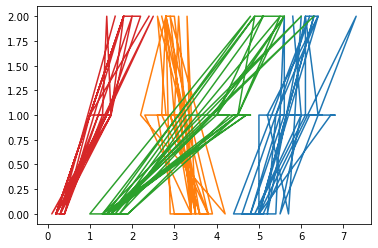

In [209]:
plt.plot(x_test,y_test_pred)

In [210]:
from sklearn.metrics import accuracy_score

In [211]:
accuracy_score( y_test,y_test_pred)

0.9736842105263158

In [212]:
confusion_matrix(y_train,y_train_pred)

array([[37,  0,  0],
       [ 0, 32,  2],
       [ 0,  0, 41]], dtype=int64)

In [213]:
mt = confusion_matrix(y_test,y_test_pred)
print(mt)

[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]


In [214]:
dot_data = export_graphviz(clf,out_file = None)
graph = pydotplus.graph_from_dot_data(dot_data)
dot_data

'digraph Tree {\nnode [shape=box] ;\n0 [label="X[3] <= 0.8\\ngini = 0.665\\nsamples = 112\\nvalue = [37, 34, 41]"] ;\n1 [label="gini = 0.0\\nsamples = 37\\nvalue = [37, 0, 0]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="X[2] <= 4.95\\ngini = 0.496\\nsamples = 75\\nvalue = [0, 34, 41]"] ;\n0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n3 [label="X[3] <= 1.65\\ngini = 0.153\\nsamples = 36\\nvalue = [0, 33, 3]"] ;\n2 -> 3 ;\n4 [label="gini = 0.0\\nsamples = 32\\nvalue = [0, 32, 0]"] ;\n3 -> 4 ;\n5 [label="gini = 0.375\\nsamples = 4\\nvalue = [0, 1, 3]"] ;\n3 -> 5 ;\n6 [label="X[2] <= 5.05\\ngini = 0.05\\nsamples = 39\\nvalue = [0, 1, 38]"] ;\n2 -> 6 ;\n7 [label="gini = 0.375\\nsamples = 4\\nvalue = [0, 1, 3]"] ;\n6 -> 7 ;\n8 [label="gini = 0.0\\nsamples = 35\\nvalue = [0, 0, 35]"] ;\n6 -> 8 ;\n}'

[Text(125.55000000000001, 190.26, 'X[3] <= 0.8\ngini = 0.665\nsamples = 112\nvalue = [37, 34, 41]'),
 Text(83.7, 135.9, 'gini = 0.0\nsamples = 37\nvalue = [37, 0, 0]'),
 Text(167.4, 135.9, 'X[2] <= 4.95\ngini = 0.496\nsamples = 75\nvalue = [0, 34, 41]'),
 Text(83.7, 81.53999999999999, 'X[3] <= 1.65\ngini = 0.153\nsamples = 36\nvalue = [0, 33, 3]'),
 Text(41.85, 27.180000000000007, 'gini = 0.0\nsamples = 32\nvalue = [0, 32, 0]'),
 Text(125.55000000000001, 27.180000000000007, 'gini = 0.375\nsamples = 4\nvalue = [0, 1, 3]'),
 Text(251.10000000000002, 81.53999999999999, 'X[2] <= 5.05\ngini = 0.05\nsamples = 39\nvalue = [0, 1, 38]'),
 Text(209.25, 27.180000000000007, 'gini = 0.375\nsamples = 4\nvalue = [0, 1, 3]'),
 Text(292.95, 27.180000000000007, 'gini = 0.0\nsamples = 35\nvalue = [0, 0, 35]')]

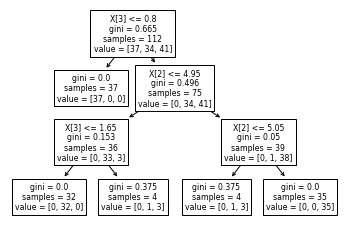

In [215]:
from sklearn import tree

tree.plot_tree(clf.fit(x_train, y_train)) 


[Text(133.92000000000002, 190.26, 'X[3] <= 0.7\ngini = 0.65\nsamples = 38\nvalue = [13, 16, 9]'),
 Text(66.96000000000001, 135.9, 'gini = 0.0\nsamples = 13\nvalue = [13, 0, 0]'),
 Text(200.88000000000002, 135.9, 'X[3] <= 1.7\ngini = 0.461\nsamples = 25\nvalue = [0, 16, 9]'),
 Text(133.92000000000002, 81.53999999999999, 'X[2] <= 5.35\ngini = 0.111\nsamples = 17\nvalue = [0, 16, 1]'),
 Text(66.96000000000001, 27.180000000000007, 'gini = 0.0\nsamples = 16\nvalue = [0, 16, 0]'),
 Text(200.88000000000002, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(267.84000000000003, 81.53999999999999, 'gini = 0.0\nsamples = 8\nvalue = [0, 0, 8]')]

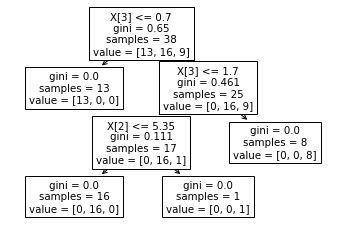

In [216]:
tree.plot_tree(clf.fit(x_test, y_test)) 